<div class="alert alert-success">

# Algorithme des k plus proches voisins 
## knn : k nearest neighbours
</div>

Voir présentation sur le fichier 'P7-3-knn-TP.pdf'

<div class="alert alert-info">
    
# I- Préparation des données
    
Le fichier `JoueursTop14.csv` contient les données sur tous les joueurs de rugby du Top14 pour la saison 2019-2020 (*trouvé sur http://www.allrugby.com*).

</div>

### I-a Import des données avec le module csv et sa fonction `DictReader`
On récupère ainsi la liste des descripteurs et les données sont stockées dans une liste de dictionnaires.

In [1]:
import csv

with open('JoueursTop14.csv', 'r', encoding='utf-8') as f:
    joueurs_top14 = csv.DictReader(f, delimiter=';')
    descripteurs = joueurs_top14.fieldnames
    joueurs_top14 = list(joueurs_top14) # on transforme l'objet DictReader en une liste standard

In [2]:
# affichage des descripteurs
print(descripteurs) 

['Equipe', 'Nom', 'Poste', 'Type poste', 'Date de naissance', 'Taille (en cm)', 'Poids (en kg)']


In [3]:
# Exemple :  
joueurs_top14[0] # sélection du 1er joueur de la liste

{'Equipe': 'Agen',
 'Nom': 'Anton PEIKRISHVILI',
 'Poste': 'Pilier',
 'Type poste': 'Avant',
 'Date de naissance': '18/09/1987',
 'Taille (en cm)': '183',
 'Poids (en kg)': '122'}

### I-b Séparation des données : une partie pour créer l'algo knn et une partie pour faire des tests
On crée une 1ère liste avec tous les joueurs qui ne sont pas de Toulouse (choix arbitraire !) et une 2ème liste avec seulement les joueurs de Toulouse. La 1ère liste servira de jeu de données de travail pour développer l'algorithme et la 2ème liste servira pour les tests.

Au passage, on conserve seulement les données Poids, Taille et Type de poste.
Et par ailleurs, on convertit les Poids et Taille en entiers (ce sont des chaines de caractères dans le fichier source).

In [4]:
# jeu de données utiles
joueurs = [{'taille': int(joueur["Taille (en cm)"]), 'poids': int(joueur["Poids (en kg)"]), 'poste': joueur["Type poste"]}
           for joueur in joueurs_top14 if joueur["Equipe"] != "Toulouse"]

In [5]:
# Exemple : 
joueurs[0]

{'taille': 183, 'poids': 122, 'poste': 'Avant'}

<div class="alert alert-warning">
    
**Exo** : Créer la variable `toulousains` qui contient la liste des seuls joueurs de Toulouse sur le même modèle que la liste précédente des joueurs qui ne sont pas de Toulouse :
    
</div>

In [6]:
# jeu de tests (variable nommée toulousains)
### A VOUS DE JOUER
# toulousains = ...

In [7]:
# jeu de tests (variable nommée toulousains)
### A VOUS DE JOUER
toulousains = [{'taille': int(joueur["Taille (en cm)"]), 'poids': int(joueur["Poids (en kg)"]), 'poste': joueur["Type poste"]}
           for joueur in joueurs_top14 if joueur["Equipe"] == "Toulouse"]

In [8]:
# Exemple : affichage du 1er joueur de Toulouse :
toulousains[0]

{'taille': 184, 'poids': 128, 'poste': 'Avant'}

<div class="alert alert-info">
    
# II- Représentation visuelle des données
On désire représenter ces données dans un graphique de corpulence : chaque joueur est représenté par un point avec sa taille en abscisse et son poids en ordonnée. 

Par ailleurs, on choisira une représentation différente (couleur et symbole du point) en fonction du type de poste occupé par le joueur.

</div>

L'utilisation du module `matplotlib` n'est pas strictement au programme de NSI, mais est souvent utile pour ceux qui font spé Physique (entre autres). Vous êtes donc invités à essayer de comprendre les lignes suivantes.

In [9]:
import matplotlib.pyplot as plt

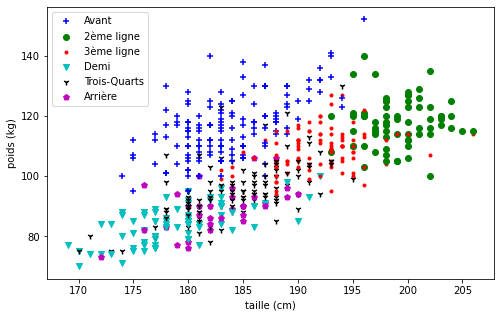

In [10]:
# initialisation d'un graphe
plt.figure(figsize=(8, 5))

# définition des paramètres de représentations (aspect esthétique : couleur et symbole des points)
# liste des types de postes existants :
postes = ['Avant', '2ème ligne', '3ème ligne', 'Demi', 'Trois-Quarts', 'Arrière']     
symboles = ['+', 'o', '.', 'v', '1', 'p']
couleurs = ['b', 'g', 'r', 'c', 'k', 'm']
symboles = {poste:symbole for (poste, symbole) in zip(postes, symboles)}
couleurs = {poste:symbole for (poste, symbole) in zip(postes, couleurs)}

# tracé des points
for joueur in joueurs:
    # documentation de plt.scatter() = affichage de points dans un graphe :
    # plt.scatter(abscisse, ordonnée, label="légende", marker="symbole du pt", color="couleur")
    plt.scatter(joueur['taille'], joueur['poids'], marker=symboles[joueur['poste']], color=couleurs[joueur['poste']])

# définition des axes 
plt.xlabel('taille (cm)')
plt.ylabel('poids (kg)')

# création de la légende
for poste in postes:
    plt.scatter(0, 0, label=poste, marker=symboles[poste], color=couleurs[poste])
plt.legend()

# affichage du graphique
plt.show()

#### Commentaire :
On distingue sur ce graphique des zones dans lesquelles les joueurs sont plus ou moins représentés en fonction de leur type de poste.

(Remarque : Les "Arrière" sont sans doute les plus difficiles à identifier)

<div class="alert alert-info">
    
# III- Implémentation de l'algorithme des k plus proches voisins
On dispose d’une banque de données d’apprentissage. À l’aide des similarités avec les exemples de cette base,
l’algorithme doit classer les exemples non étiquetés.

Dans notre contexte, on souhaite déterminer quel est le poste occupé par un joueur connaissant sa taille et son poids.

</div>

### III-a Définition d'une "distance" entre deux joueurs :
On définit la "distance" entre deux joueurs comme la distance euclidienne entre leurs points dans un graphe de corpulence poids = f(taille). 

Un joueur est caractérisé par un couple de corpulence (T, P), représentable par un point dans un graphique (voir section précédente).

Avec notre implémentation d'un joueur sous forme de dictionnaire, on a :
- T = joueur['taille']
- P = joueur['poids']

Pour 2 joueurs $A(T_A, P_A)$ et $B(T_B, P_B)$, la "distance" qui les sépare est définie par : $d=\sqrt{(T_A - T_B)^2 + (P_A - P_B)^2}$

<div class="alert alert-warning">
    
**Exo** : écrire le code de la fonction `distance(joueurA, joueurB)`
    
</div>

In [11]:
from math import sqrt # fonction racine carrée

In [12]:
def distance(joueurA, joueurB):
    """ Renvoie la distance euclidienne entre deux joueurs identifiés par les points A(T_A, P_A) et B(T_B, P_B) 
    dans un graphique de corpulence .
    """
    ### A VOUS DE JOUER
    # ...

In [13]:
def distance(joueurA, joueurB):
    """ Renvoie la distance euclidienne entre deux joueurs identifiés par les points A(T_A, P_A) et B(T_B, P_B) 
    dans un graphique de corpulence .
    """
    ### SOLUTION
    return sqrt((joueurA['taille']-joueurB['taille'])**2 + (joueurA['poids']-joueurB['poids'])**2)

### III-b Obtention des k plus proches voisins avec leur distance et la catégorie de poste associé
Il s'agit de parcourir tous les joueurs de la liste de données de travail et de calculer la distance qui les sépare d'un joueur-test défini par sa corpulence (taille, poids).

La fonction `knn` correspondante renvoie une liste contenant des couples (distance, poste).

Ex : `[(2.3, "Demi"), (3.51, "Trois-Quarts"), (4.0, "Trois-Quarts"), ...]`

La liste doit aussi être **triée par distance croissante** et sa **taille doit être limitée à k éléments** (on ne conserve que les k plus proches voisins).

<div class="alert alert-warning">
    
**Exo** : écrire la fonction `knn`: 
    
</div>

In [14]:
def knn(joueur_test, joueurs, k):
    """ Renvoie la liste des k plus proches voisins d'un joueur-test caractérisé par sa corpulence (T, P)
    parmi tous les joueurs définis de la liste 'joueurs'.
    Cette liste fournit les distances et le type de poste de chaque voisin. 
    Entrées :
    - joueur_test : dict : dictionnaire caractérisant un joueur test (de corpulence connue, mais de poste inconnu).
    - joueurs : list(dict) : liste des joueurs voisins du joueur test.
    - k : int : nombre de voisins les plus proches à retenir.
    Sortie : Liste de k tuples (distance, poste), triés par distance.
    """
    ### A VOUS DE JOUER
    # ...

In [15]:
def knn(joueur_test, joueurs, k):
    """ Renvoie la liste des k plus proches voisins d'un joueur-test caractérisé par sa corpulence (T, P)
    parmi tous les joueurs définis de la liste 'joueurs'.
    Cette liste fournit les distances et le type de poste de chaque voisin. 
    Entrées :
    - joueur_test : dict : dictionnaire caractérisant un joueur test (de corpulence connue, mais de poste inconnu).
    - joueurs : list(dict) : liste des joueurs voisins du joueur test.
    - k : int : nombre de voisins les plus proches à retenir.
    Sortie : Liste de k tuples (distance, poste), triés par distance.
    """
    ### SOLUTION
    voisins = [] 
    for joueur in joueurs:
        voisins.append((distance(joueur_test, joueur), joueur['poste']))    
    return sorted(voisins)[:k] # on trie par distance, et on conserve les k premiers élements de la liste

In [16]:
# exemple : liste des 6 plus proches voisins (parmi tous les joueurs) d'un joueur de 192 cm et 91 kg :
joueur_test = {'taille':192, 'poids':91, 'poste':'inconnu'}
k = 6
knn(joueur_test, joueurs, k)

[(2.23606797749979, 'Demi'),
 (2.8284271247461903, 'Trois-Quarts'),
 (3.0, 'Trois-Quarts'),
 (3.605551275463989, 'Arrière'),
 (3.605551275463989, 'Arrière'),
 (3.605551275463989, 'Trois-Quarts')]

### III-c Dernière étape : prévoir quel poste occupe un joueur de corpulence donnée
La fonction `prévision` doit renvoyer un poste à partir de la corpulence d'un joueur-test.

Ex : `prevision(joueur_test, joueurs, 6)` vaut `'Trois-Quarts'`

<div class="alert alert-warning">
    
**Exo** : écrire la fonction `prevision`: 
    
</div>

In [17]:
def prevision(joueur_test, joueurs, k):
    """ Renvoie le poste prévisible d'un joueur en fonction de sa corpulence (T, P).
    'joueurs' est la liste des joueurs de la banque de travail.
    """
    ### A VOUS DE JOUER
    # ...

In [18]:
def prevision(joueur_test, joueurs, k):
    """ Renvoie le poste prévisible d'un joueur en fonction de sa corpulence (T, P).
    'joueurs' est la liste des joueurs de la banque de travail.
    """
    ### SOLUTION
    proches_voisins = knn(joueur_test, joueurs, k)
    # on compte le nombre de voisins de chaque type de poste parmi les k plus proches
    postes = ['Avant', '2ème ligne', '3ème ligne', 'Demi', 'Trois-Quarts', 'Arrière']     
    compte_postes = {poste:0 for poste in postes}
    for voisin in proches_voisins:
        compte_postes[voisin[1]] += 1
    # on trie les items du dictionnaire selon l'effectif du type de poste (par effectif décroissant)
    compte_postes_tri = sorted(compte_postes.items(), key=lambda t:t[1], reverse=True)
    #print(compte_postes_tri)
    # on renvoie le type de poste le représenté (le "1er venu" en cas égalité)
    return compte_postes_tri[0][0]

In [19]:
# exemple : prévision du poste d'un joueur 192 cm et 91 kg (avec k = 6):
k = 6
prevision(joueur_test, joueurs, k)

'Trois-Quarts'

<div class="alert alert-info">
    
# IV- Test du modèle 
Pour évaluer la pertinence des prévisions (et éventuellement pouvoir choisir un paramètre k convenable), on réalise une série de prévisions sur un jeu de données test. 

Dans notre exemple, le jeu de données test est la liste des joueurs de Toulouse.

On va donc comparer le poste rééellement occupé par chaque Toulousain et le poste prévu par l'algorithme knn pour voir si les prévisions sont pertinentes.

</div>

In [20]:
# rappel des données qu'on possède :

print("3 joueurs de Toulouse (données test):")
for i in range(3):
    print(toulousains[i])
    
print()
print("3 joueurs parmi tous les autres (données de travail):")
for i in range(3):
    print(joueurs[i])

3 joueurs de Toulouse (données test):
{'taille': 184, 'poids': 128, 'poste': 'Avant'}
{'taille': 183, 'poids': 110, 'poste': 'Avant'}
{'taille': 182, 'poids': 116, 'poste': 'Avant'}

3 joueurs parmi tous les autres (données de travail):
{'taille': 183, 'poids': 122, 'poste': 'Avant'}
{'taille': 183, 'poids': 116, 'poste': 'Avant'}
{'taille': 177, 'poids': 112, 'poste': 'Avant'}


###  IV-a Qualité des prévisions  sur un jeu de données test
Choisir un paramètre k = 4, et afficher pour chaque joueur de Toulouse, son poste réel, et la catégorie prévue par l'algorithme des k plus proches voisins.

In [22]:
k = 4 # paramètre de l'algo

for joueur in toulousains:
    poste_prevu = prevision(joueur, joueurs, k)  # poste_prevu est le poste déterminé en appliqant l'algo knn
    print(joueur['poste'], poste_prevu)          # joueur['poste'] est le poste réel du joueur testé

Avant Avant
Avant Avant
Avant Avant
Avant Avant
Avant Avant
Avant Avant
Avant Avant
Avant Avant
Avant Trois-Quarts
Avant 3ème ligne
Avant 3ème ligne
Avant Trois-Quarts
Avant Avant
2ème ligne 2ème ligne
2ème ligne 2ème ligne
2ème ligne 2ème ligne
2ème ligne 2ème ligne
2ème ligne 2ème ligne
2ème ligne 2ème ligne
3ème ligne 3ème ligne
3ème ligne 3ème ligne
3ème ligne 3ème ligne
3ème ligne Trois-Quarts
3ème ligne 2ème ligne
3ème ligne 3ème ligne
3ème ligne 3ème ligne
3ème ligne 2ème ligne
3ème ligne Avant
Demi Demi
Demi Demi
Demi Demi
Demi Demi
Demi Demi
Demi Demi
Trois-Quarts Trois-Quarts
Trois-Quarts 3ème ligne
Trois-Quarts 3ème ligne
Trois-Quarts Trois-Quarts
Trois-Quarts Trois-Quarts
Trois-Quarts Demi
Trois-Quarts 3ème ligne
Trois-Quarts Trois-Quarts
Trois-Quarts Demi
Trois-Quarts Trois-Quarts
Arrière Trois-Quarts
Arrière Demi
Arrière Demi


#### Commentaire :
**Les résultats sont plutôts satifaisants, même s'il reste quand même quelques erreurs...**

### IV-b Statistiques de réussites de prévisions en fonction de k
On peut essayer différentes valeurs de k pour voir si les prévisions peuvent être améliorées.



<div class="alert alert-warning">
    
**Exo** : Écrire une fonction `pourcentage_reussite` qui renvoie le pourcentage (arrondi au nombre entier entre 0 et 100) de bonnes prévisions.
    
</div>

In [23]:
def pourcentage_reussite(donnees_tests, donnees_travail, k):
    """ Renvoie le pourcentage de bonnes prévisions des postes 
    parmi les joueurs de la liste donnees_test 
    en s'appuyant sur les joueurs de liste donnees_travail.
    """
    ### A VOUS DE JOUER
    # ...

In [24]:
def pourcentage_reussite(donnees_tests, donnees_travail, k):
    """ Renvoie le pourcentage de bonnes prévisions des postes 
    parmi les joueurs de la liste donnees_test 
    en s'appuyant sur les joueurs de liste donnees_travail.
    """
    ### SOLUTION
    bonnes_previsions = 0
    for joueur in donnees_tests:
        poste_prevu = prevision(joueur, joueurs, k)
        if poste_prevu == joueur['poste']:
            bonnes_previsions += 1

    return int(100 * bonnes_previsions / len(donnees_tests))

In [25]:
for k in range(3, 12):
    print(k, pourcentage_reussite(toulousains, joueurs, k))

3 68
4 65
5 65
6 65
7 72
8 68
9 70
10 70
11 70


#### Commentaire :
Finalement, on constate ici que la valeur de k n'est pas trop critique et que le pourcentage de bonnes réponses reste aux alentours de 70%.

Ceci montre aussi la limite de ce modèle de prédiction. Mais la qualité des résultats obtenus est bien entendue dépendante de chaque situation étudiée.